In [2]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.utils import np_utils
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint

In [3]:
def make_model():
    k = float(np.random.rand()*1+0.2)
    print ('## k = %.3f' % k)
    winit1 = k/np.sqrt(5*5*1)
    winit2 = k/np.sqrt(5*5*64)
    winit3 = k/np.sqrt(5*5*128)


    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=5, padding='same',
                    data_format='channels_first',
                    use_bias=False, 
                    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=winit1),
                    activation='relu', input_shape=(1,96,96)))
    model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=5, padding='same',
                    data_format='channels_first',
                    use_bias=False,
                    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=winit2),
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=5, padding='same',
                    data_format='channels_first',
                    use_bias=False,
                    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=winit3),
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=12, strides=(12,12)))
    model.add(Flatten())

    winitD1 = k/np.sqrt(4032)
    winitD2 = k/np.sqrt(300)
    model.add(Dropout(0.5))
    model.add(Dense(300, activation='relu',
                    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05),
                    bias_initializer='Ones'))

    model.add(Dense(8, activation='softmax',
    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=winitD2),
    bias_initializer='Zeros'))

    print(model.summary())
    
    # compile the model
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd,
             metrics=['accuracy'])

    return model

In [4]:
def make_cv_folds(X, y, folds, fold_num):
    X_train = []
    y_train = []
    X_valid = []
    y_valid = []

    for index, fold in enumerate(folds):
        if fold == fold_num:
            X_valid.append(X[index])
            y_valid.append(y[index])
        else:
            X_train.append(X[index])
            y_train.append(y[index])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)


    return X_train, y_train, X_valid, y_valid

In [5]:
# Data loading
dataset_path = 'save_data/npy_files'
result_path = 'result/'
X = np.load(os.path.join(dataset_path,'X.npy'))
y = np.load(os.path.join(dataset_path,'y.npy'))
folds = np.load(os.path.join(dataset_path,'folds.npy'))

# rescale [0,255] -> [0,2]    
X = X.astype('float32')/255*2

# one-hot encode the labels
num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)

In [12]:
result_path = './result/test'
val_fold = 0
X_train, y_train, X_valid, y_valid = make_cv_folds(X, y, folds, val_fold)

print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)


# printing number of training, validation, and test images
print(X_train.shape[0], 'train samples')
#print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')
#X_test = X_test.astype('float32')/255
model = make_model()
filepath="weights-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath = os.path.join(result_path, filepath)
checkpointer = ModelCheckpoint(filepath=filepath,
                        verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, batch_size=64, epochs=1000,
            validation_data=(X_valid, y_valid),
            callbacks=[checkpointer], verbose=2, shuffle=True)

X_train shape : (1175, 1, 96, 96)
y_train shape : (1175, 8)
1175 train samples
132 validation samples
## k = 0.376
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 96, 96)        1600      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 48, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 48, 96)       102400    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 24, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 24, 96)       409600    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 21, 2, 96)         0         
___________________________

Epoch 42/1000
Epoch 00042: val_loss improved from 0.49094 to 0.41482, saving model to ./result/test/weights-42-0.90.hdf5
 - 1s - loss: 0.0973 - acc: 0.9634 - val_loss: 0.4148 - val_acc: 0.9015
Epoch 43/1000
Epoch 00043: val_loss did not improve
 - 1s - loss: 0.1251 - acc: 0.9532 - val_loss: 0.5502 - val_acc: 0.8939
Epoch 44/1000
Epoch 00044: val_loss did not improve
 - 1s - loss: 0.0851 - acc: 0.9702 - val_loss: 0.6239 - val_acc: 0.8864
Epoch 45/1000
Epoch 00045: val_loss did not improve
 - 1s - loss: 0.1009 - acc: 0.9702 - val_loss: 0.6967 - val_acc: 0.8712
Epoch 46/1000
Epoch 00046: val_loss did not improve
 - 1s - loss: 0.0707 - acc: 0.9728 - val_loss: 0.7931 - val_acc: 0.8864
Epoch 47/1000
Epoch 00047: val_loss did not improve
 - 1s - loss: 0.0904 - acc: 0.9660 - val_loss: 0.9606 - val_acc: 0.8561
Epoch 48/1000
Epoch 00048: val_loss did not improve
 - 1s - loss: 0.1070 - acc: 0.9651 - val_loss: 0.6583 - val_acc: 0.8106
Epoch 49/1000
Epoch 00049: val_loss did not improve
 - 1s - los

Epoch 108/1000
Epoch 00108: val_loss did not improve
 - 1s - loss: 0.0720 - acc: 0.9787 - val_loss: 0.9614 - val_acc: 0.8636
Epoch 109/1000
Epoch 00109: val_loss did not improve
 - 1s - loss: 0.0696 - acc: 0.9796 - val_loss: 1.0881 - val_acc: 0.8182
Epoch 110/1000
Epoch 00110: val_loss did not improve
 - 1s - loss: 0.0386 - acc: 0.9864 - val_loss: 0.7694 - val_acc: 0.8939
Epoch 111/1000
Epoch 00111: val_loss did not improve
 - 1s - loss: 0.0541 - acc: 0.9830 - val_loss: 1.0634 - val_acc: 0.8333
Epoch 112/1000
Epoch 00112: val_loss did not improve
 - 1s - loss: 0.0247 - acc: 0.9923 - val_loss: 1.1094 - val_acc: 0.8712
Epoch 113/1000
Epoch 00113: val_loss did not improve
 - 1s - loss: 0.0714 - acc: 0.9796 - val_loss: 0.7248 - val_acc: 0.8712
Epoch 114/1000
Epoch 00114: val_loss did not improve
 - 1s - loss: 0.0373 - acc: 0.9872 - val_loss: 1.2054 - val_acc: 0.8333
Epoch 115/1000
Epoch 00115: val_loss did not improve
 - 1s - loss: 0.0382 - acc: 0.9881 - val_loss: 1.0146 - val_acc: 0.8636


Epoch 174/1000
Epoch 00174: val_loss did not improve
 - 1s - loss: 0.1154 - acc: 0.9804 - val_loss: 1.1202 - val_acc: 0.8030
Epoch 175/1000
Epoch 00175: val_loss did not improve
 - 1s - loss: 0.0775 - acc: 0.9745 - val_loss: 1.2785 - val_acc: 0.8333
Epoch 176/1000
Epoch 00176: val_loss did not improve
 - 1s - loss: 0.0905 - acc: 0.9787 - val_loss: 1.0933 - val_acc: 0.7803
Epoch 177/1000
Epoch 00177: val_loss did not improve
 - 1s - loss: 0.1786 - acc: 0.9643 - val_loss: 1.1844 - val_acc: 0.8788
Epoch 178/1000
Epoch 00178: val_loss did not improve
 - 1s - loss: 0.1504 - acc: 0.9609 - val_loss: 1.6692 - val_acc: 0.7500
Epoch 179/1000
Epoch 00179: val_loss did not improve
 - 1s - loss: 0.1217 - acc: 0.9600 - val_loss: 1.0471 - val_acc: 0.8712
Epoch 180/1000
Epoch 00180: val_loss did not improve
 - 1s - loss: 0.1603 - acc: 0.9702 - val_loss: 1.6698 - val_acc: 0.8030
Epoch 181/1000
Epoch 00181: val_loss did not improve
 - 1s - loss: 0.1615 - acc: 0.9643 - val_loss: 1.0479 - val_acc: 0.8561


Epoch 240/1000
Epoch 00240: val_loss did not improve
 - 1s - loss: 8.4688e-04 - acc: 1.0000 - val_loss: 0.9344 - val_acc: 0.8939
Epoch 241/1000
Epoch 00241: val_loss did not improve
 - 1s - loss: 0.0122 - acc: 0.9974 - val_loss: 0.9247 - val_acc: 0.8864
Epoch 242/1000
Epoch 00242: val_loss did not improve
 - 1s - loss: 0.0075 - acc: 0.9966 - val_loss: 1.1014 - val_acc: 0.8636
Epoch 243/1000
Epoch 00243: val_loss did not improve
 - 1s - loss: 0.0108 - acc: 0.9966 - val_loss: 1.0396 - val_acc: 0.8561
Epoch 244/1000
Epoch 00244: val_loss did not improve
 - 1s - loss: 0.0141 - acc: 0.9983 - val_loss: 1.2537 - val_acc: 0.8409
Epoch 245/1000
Epoch 00245: val_loss did not improve
 - 1s - loss: 0.0106 - acc: 0.9974 - val_loss: 1.1071 - val_acc: 0.8636
Epoch 246/1000
Epoch 00246: val_loss did not improve
 - 1s - loss: 0.0081 - acc: 0.9966 - val_loss: 1.0108 - val_acc: 0.8712
Epoch 247/1000
Epoch 00247: val_loss did not improve
 - 1s - loss: 0.0072 - acc: 0.9983 - val_loss: 1.0102 - val_acc: 0.8

Epoch 305/1000
Epoch 00305: val_loss did not improve
 - 1s - loss: 0.0065 - acc: 0.9974 - val_loss: 1.1475 - val_acc: 0.8636
Epoch 306/1000
Epoch 00306: val_loss did not improve
 - 1s - loss: 0.0224 - acc: 0.9957 - val_loss: 0.8875 - val_acc: 0.9015
Epoch 307/1000
Epoch 00307: val_loss did not improve
 - 1s - loss: 0.0291 - acc: 0.9923 - val_loss: 1.0236 - val_acc: 0.8788
Epoch 308/1000
Epoch 00308: val_loss did not improve
 - 1s - loss: 0.0282 - acc: 0.9966 - val_loss: 0.8242 - val_acc: 0.9242
Epoch 309/1000
Epoch 00309: val_loss did not improve
 - 1s - loss: 0.0068 - acc: 0.9966 - val_loss: 1.0508 - val_acc: 0.8788
Epoch 310/1000
Epoch 00310: val_loss did not improve
 - 1s - loss: 0.0139 - acc: 0.9949 - val_loss: 0.9153 - val_acc: 0.9167
Epoch 311/1000
Epoch 00311: val_loss did not improve
 - 1s - loss: 0.0034 - acc: 0.9983 - val_loss: 0.8678 - val_acc: 0.9242
Epoch 312/1000
Epoch 00312: val_loss did not improve
 - 1s - loss: 7.4535e-04 - acc: 1.0000 - val_loss: 0.8018 - val_acc: 0.9

Epoch 371/1000
Epoch 00371: val_loss did not improve
 - 1s - loss: 0.0025 - acc: 0.9991 - val_loss: 0.8925 - val_acc: 0.9242
Epoch 372/1000
Epoch 00372: val_loss did not improve
 - 1s - loss: 7.2845e-04 - acc: 1.0000 - val_loss: 0.8738 - val_acc: 0.9318
Epoch 373/1000
Epoch 00373: val_loss did not improve
 - 1s - loss: 0.0070 - acc: 0.9983 - val_loss: 0.9082 - val_acc: 0.9091
Epoch 374/1000
Epoch 00374: val_loss did not improve
 - 1s - loss: 4.4776e-04 - acc: 1.0000 - val_loss: 0.9870 - val_acc: 0.8864
Epoch 375/1000
Epoch 00375: val_loss did not improve
 - 1s - loss: 5.2907e-04 - acc: 1.0000 - val_loss: 0.9880 - val_acc: 0.8864
Epoch 376/1000
Epoch 00376: val_loss did not improve
 - 1s - loss: 5.8154e-04 - acc: 1.0000 - val_loss: 0.9562 - val_acc: 0.8939
Epoch 377/1000
Epoch 00377: val_loss did not improve
 - 1s - loss: 0.0020 - acc: 0.9983 - val_loss: 0.9049 - val_acc: 0.9015
Epoch 378/1000
Epoch 00378: val_loss did not improve
 - 1s - loss: 0.0037 - acc: 0.9983 - val_loss: 0.9521 - 

Epoch 437/1000
Epoch 00437: val_loss did not improve
 - 1s - loss: 0.0084 - acc: 0.9974 - val_loss: 1.2413 - val_acc: 0.8636
Epoch 438/1000
Epoch 00438: val_loss did not improve
 - 1s - loss: 0.0040 - acc: 0.9983 - val_loss: 1.1161 - val_acc: 0.8864
Epoch 439/1000
Epoch 00439: val_loss did not improve
 - 1s - loss: 0.0149 - acc: 0.9974 - val_loss: 1.0878 - val_acc: 0.8864
Epoch 440/1000
Epoch 00440: val_loss did not improve
 - 1s - loss: 0.0120 - acc: 0.9966 - val_loss: 0.8550 - val_acc: 0.9015
Epoch 441/1000
Epoch 00441: val_loss did not improve
 - 1s - loss: 0.0117 - acc: 0.9966 - val_loss: 1.1931 - val_acc: 0.8788
Epoch 442/1000
Epoch 00442: val_loss did not improve
 - 1s - loss: 0.0159 - acc: 0.9974 - val_loss: 1.0837 - val_acc: 0.8788
Epoch 443/1000
Epoch 00443: val_loss did not improve
 - 1s - loss: 0.0169 - acc: 0.9974 - val_loss: 0.8800 - val_acc: 0.8939
Epoch 444/1000
Epoch 00444: val_loss did not improve
 - 1s - loss: 0.0105 - acc: 0.9966 - val_loss: 1.1754 - val_acc: 0.8939


Epoch 502/1000
Epoch 00502: val_loss did not improve
 - 1s - loss: 1.3678e-04 - acc: 1.0000 - val_loss: 0.9403 - val_acc: 0.8939
Epoch 503/1000
Epoch 00503: val_loss did not improve
 - 1s - loss: 9.2368e-05 - acc: 1.0000 - val_loss: 0.9354 - val_acc: 0.9015
Epoch 504/1000
Epoch 00504: val_loss did not improve
 - 1s - loss: 6.1140e-05 - acc: 1.0000 - val_loss: 0.9346 - val_acc: 0.9015
Epoch 505/1000
Epoch 00505: val_loss did not improve
 - 1s - loss: 1.1254e-05 - acc: 1.0000 - val_loss: 0.9345 - val_acc: 0.9015
Epoch 506/1000
Epoch 00506: val_loss did not improve
 - 1s - loss: 5.8823e-05 - acc: 1.0000 - val_loss: 0.9305 - val_acc: 0.9015
Epoch 507/1000
Epoch 00507: val_loss did not improve
 - 1s - loss: 6.4309e-04 - acc: 1.0000 - val_loss: 0.9206 - val_acc: 0.8864
Epoch 508/1000
Epoch 00508: val_loss did not improve
 - 1s - loss: 3.1842e-04 - acc: 1.0000 - val_loss: 0.8903 - val_acc: 0.8864
Epoch 509/1000
Epoch 00509: val_loss did not improve
 - 1s - loss: 0.0012 - acc: 0.9991 - val_los

Epoch 567/1000
Epoch 00567: val_loss did not improve
 - 1s - loss: 0.0088 - acc: 0.9983 - val_loss: 1.2685 - val_acc: 0.8561
Epoch 568/1000
Epoch 00568: val_loss did not improve
 - 1s - loss: 0.0082 - acc: 0.9983 - val_loss: 1.1153 - val_acc: 0.8864
Epoch 569/1000
Epoch 00569: val_loss did not improve
 - 1s - loss: 0.0163 - acc: 0.9974 - val_loss: 1.3040 - val_acc: 0.8712
Epoch 570/1000
Epoch 00570: val_loss did not improve
 - 1s - loss: 0.0661 - acc: 0.9906 - val_loss: 2.1592 - val_acc: 0.8182
Epoch 571/1000
Epoch 00571: val_loss did not improve
 - 1s - loss: 0.0511 - acc: 0.9906 - val_loss: 1.5977 - val_acc: 0.8182
Epoch 572/1000
Epoch 00572: val_loss did not improve
 - 1s - loss: 0.0923 - acc: 0.9830 - val_loss: 1.5937 - val_acc: 0.8636
Epoch 573/1000
Epoch 00573: val_loss did not improve
 - 1s - loss: 0.1279 - acc: 0.9770 - val_loss: 1.3385 - val_acc: 0.8333
Epoch 574/1000
Epoch 00574: val_loss did not improve
 - 1s - loss: 0.0717 - acc: 0.9864 - val_loss: 1.7645 - val_acc: 0.8030


Epoch 633/1000
Epoch 00633: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 634/1000
Epoch 00634: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 635/1000
Epoch 00635: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 636/1000
Epoch 00636: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 637/1000
Epoch 00637: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 638/1000
Epoch 00638: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 639/1000
Epoch 00639: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 640/1000
Epoch 00640: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - 

Epoch 698/1000
Epoch 00698: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 699/1000
Epoch 00699: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 700/1000
Epoch 00700: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 701/1000
Epoch 00701: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 702/1000
Epoch 00702: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 703/1000
Epoch 00703: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 704/1000
Epoch 00704: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 705/1000
Epoch 00705: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - 

Epoch 763/1000
Epoch 00763: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 764/1000
Epoch 00764: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 765/1000
Epoch 00765: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 766/1000
Epoch 00766: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 767/1000
Epoch 00767: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 768/1000
Epoch 00768: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 769/1000
Epoch 00769: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 770/1000
Epoch 00770: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - 

Epoch 828/1000
Epoch 00828: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 829/1000
Epoch 00829: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 830/1000
Epoch 00830: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 831/1000
Epoch 00831: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 832/1000
Epoch 00832: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 833/1000
Epoch 00833: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 834/1000
Epoch 00834: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 835/1000
Epoch 00835: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - 

Epoch 893/1000
Epoch 00893: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 894/1000
Epoch 00894: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 895/1000
Epoch 00895: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 896/1000
Epoch 00896: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 897/1000
Epoch 00897: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 898/1000
Epoch 00898: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 899/1000
Epoch 00899: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 900/1000
Epoch 00900: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - 

Epoch 958/1000
Epoch 00958: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 959/1000
Epoch 00959: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 960/1000
Epoch 00960: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 961/1000
Epoch 00961: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 962/1000
Epoch 00962: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 963/1000
Epoch 00963: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 964/1000
Epoch 00964: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 965/1000
Epoch 00965: val_loss did not improve
 - 1s - loss: 14.3485 - acc: 0.1098 - val_loss: 15.3855 - 

In [22]:
hist.history['acc'][41]

0.9634042555220583

In [21]:
hist.history['val_acc'][41]

0.9015151515151515

In [14]:
%matplotlib inline

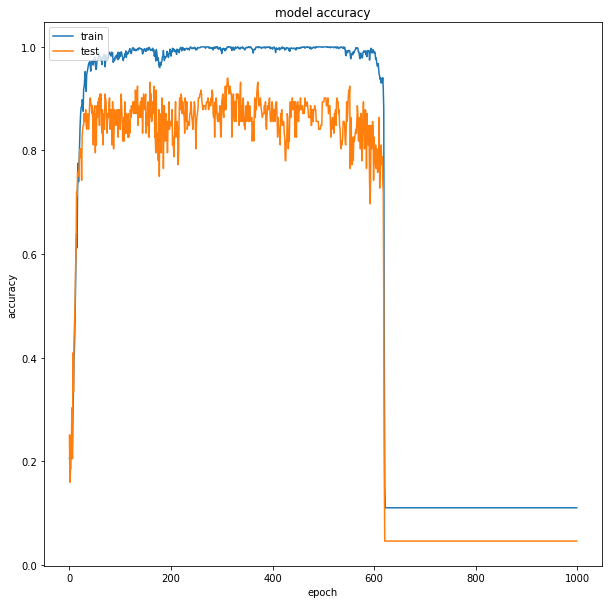

In [19]:
plt.figure(figsize=(10,10))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [24]:
with open('./result/test/model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [25]:
from keras.models import model_from_json

In [27]:
with open('./result/test/model_architecture.json', 'r') as f:
    model2 = model_from_json(f.read())

model2.load_weights('./result/test/weights-42-0.90.hdf5')

In [29]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 96, 96)        1600      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 48, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 48, 96)       102400    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 24, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 24, 96)       409600    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 21, 2, 96)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4032)              0         
__________